Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [143]:
# Resource used: https://www.tensorflow.org/tutorials/images/classification

In [3]:
import shutup; shutup.please()

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL # Python Image Library
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [5]:
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory



In [6]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [7]:
# # ## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive',force_remount=True)

# # ##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Users/yashmishra12/Documents/Skin/Train")
data_dir_test = pathlib.Path("/Users/yashmishra12/Documents/Skin/Test")

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

6739
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [24]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [26]:
train_ds = image_dataset_from_directory( directory=data_dir_train, seed = 123, labels='inferred',
#     validation_split = 0.2,
#     subset = "training",
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width))


Found 2239 files belonging to 9 classes.


In [29]:
val_ds = image_dataset_from_directory(
    directory=data_dir_test,
    seed = 123,
    labels='inferred',
#     validation_split = 0.2,
#     subset = "validation",
    label_mode='int',
    batch_size=batch_size, #BATCH size = 32
    image_size=(img_height, img_width)) # Image Size = 180 x 180

Found 118 files belonging to 9 classes.


In [30]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

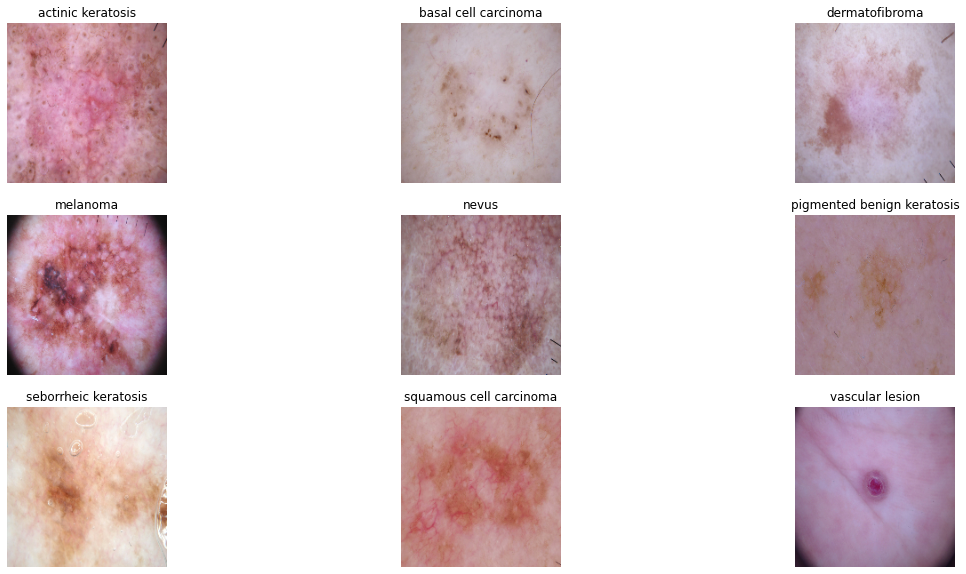

In [40]:
def format_example(x,l):
    return tf.math.equal(l[0], i)

fig = plt.figure(figsize=(20,10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(tf.autograph.experimental.do_not_convert(format_example))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [41]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [42]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [43]:
### Your code goes here
model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [44]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [45]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 90, 90, 64)        0         
                                                        

### Train the model

In [46]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size = batch_size,
  epochs=epochs
)

Epoch 1/20


2021-12-30 17:06:02.346275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 3.0167 - accuracy: 0.2827

2021-12-30 17:06:29.929427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 31s 365ms/step - loss: 3.0167 - accuracy: 0.2827 - val_loss: 2.1953 - val_accuracy: 0.2627
Epoch 2/20
70/70 [==============================] - 23s 330ms/step - loss: 1.5938 - accuracy: 0.4448 - val_loss: 1.9548 - val_accuracy: 0.3305
Epoch 3/20
70/70 [==============================] - 23s 325ms/step - loss: 1.3534 - accuracy: 0.5346 - val_loss: 2.4573 - val_accuracy: 0.2881
Epoch 4/20
70/70 [==============================] - 23s 326ms/step - loss: 1.2419 - accuracy: 0.5690 - val_loss: 2.1926 - val_accuracy: 0.2966
Epoch 5/20
70/70 [==============================] - 23s 326ms/step - loss: 1.1779 - accuracy: 0.5878 - val_loss: 2.7453 - val_accuracy: 0.3136
Epoch 6/20
70/70 [==============================] - 23s 327ms/step - loss: 0.9929 - accuracy: 0.6574 - val_loss: 2.8661 - val_accuracy: 0.3051
Epoch 7/20
70/70 [==============================] - 23s 326ms/step - loss: 0.8872 - accuracy: 0.6878 - val_loss: 3.0977 - val_accuracy: 0.3305
Epoch 8/20

### Visualizing training results

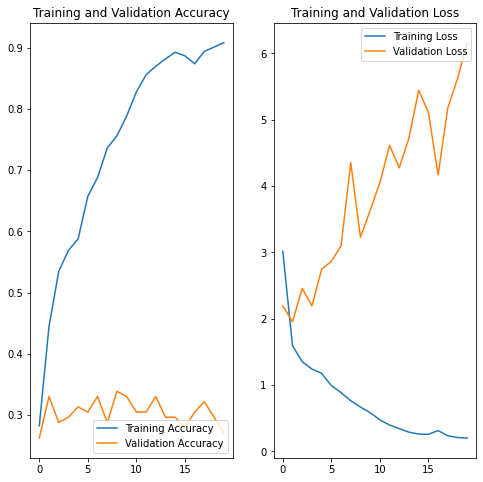

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- The model show a serious case of overfitting with training accuracy reaching 90% while validation accuracy stagnates at 30%

### Write your findings here

In [48]:
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomHeight
from tensorflow.keras.layers.experimental.preprocessing import RandomWidth

In [66]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
with tf.device('/cpu:0'):
    
    data_augmentation = tf.keras.Sequential([
          RandomRotation(seed=123, factor=(-0.1, 0.1) ),
          RandomTranslation(seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ),
          RandomFlip( mode="horizontal_and_vertical", seed=123 ),
          RandomZoom( seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ),
          RandomHeight(seed=123, factor=(-0.1,0.1)),
          RandomWidth(seed=123, factor=(-0.1,0.1))
        ])


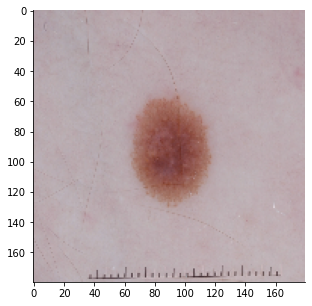

In [50]:
train_batch = train_ds.take(1)
fig = plt.figure(figsize=(10,5))
for images, label in train_batch:
    for i in range(1):
        myPic = images[i].numpy().astype("uint8")
        plt.imshow(myPic)
        sns.despine()

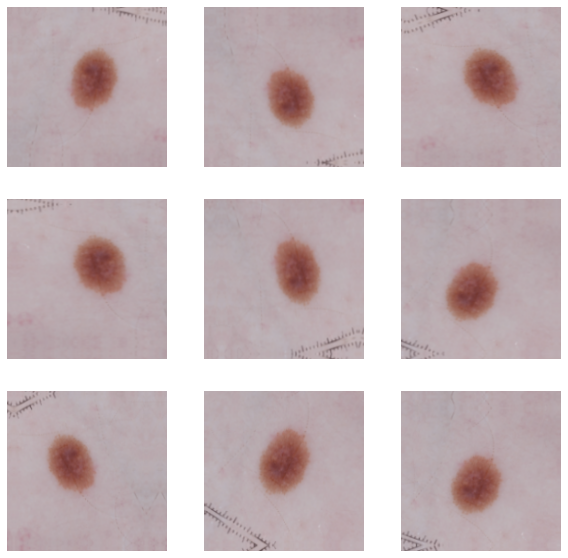

In [67]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for i in range(9):
  with tf.device('/cpu:0'):  
      augmented_image = data_augmentation(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.array(augmented_image[0],np.int32))
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [75]:
## Your code goes here
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

    #Augmentation Layers
    model.add(RandomRotation(seed=123, factor=(-0.1, 0.1) ))
    model.add(RandomTranslation(seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ))
    model.add(RandomFlip( mode="horizontal_and_vertical", seed=123 ))
    model.add(RandomZoom( seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ))



    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())


    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))




### Compiling the model

In [76]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_translation_4 (Rando  (None, 180, 180, 3)      0         
 mTranslation)                                                   
                                                                 
 random_flip_4 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)     

### Training the model

In [78]:
## Your code goes here, note: train your model for 20 epochs
# history = ## your training code
epochs = 20

with tf.device('/cpu:0'):
    history = model.fit( train_ds, validation_data=val_ds, epochs = epochs,)

Epoch 1/20


2021-12-30 17:21:51.024619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 4.4807 - accuracy: 0.1702

2021-12-30 17:22:22.140400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 32s 449ms/step - loss: 4.4807 - accuracy: 0.1702 - val_loss: 2.1841 - val_accuracy: 0.1525
Epoch 2/20
70/70 [==============================] - 31s 439ms/step - loss: 2.0277 - accuracy: 0.2117 - val_loss: 2.1298 - val_accuracy: 0.1610
Epoch 3/20
70/70 [==============================] - 31s 441ms/step - loss: 1.8062 - accuracy: 0.3448 - val_loss: 2.3106 - val_accuracy: 0.2627
Epoch 4/20
70/70 [==============================] - 31s 447ms/step - loss: 1.6660 - accuracy: 0.4029 - val_loss: 2.3134 - val_accuracy: 0.2458
Epoch 5/20
70/70 [==============================] - 32s 452ms/step - loss: 1.5718 - accuracy: 0.4515 - val_loss: 2.2598 - val_accuracy: 0.2627
Epoch 6/20
70/70 [==============================] - 31s 443ms/step - loss: 1.4849 - accuracy: 0.4850 - val_loss: 2.1167 - val_accuracy: 0.2881
Epoch 7/20
70/70 [==============================] - 30s 432ms/step - loss: 1.4545 - accuracy: 0.4882 - val_loss: 2.3719 - val_accuracy: 0.2458
Epoch 8/20

### Visualizing the results

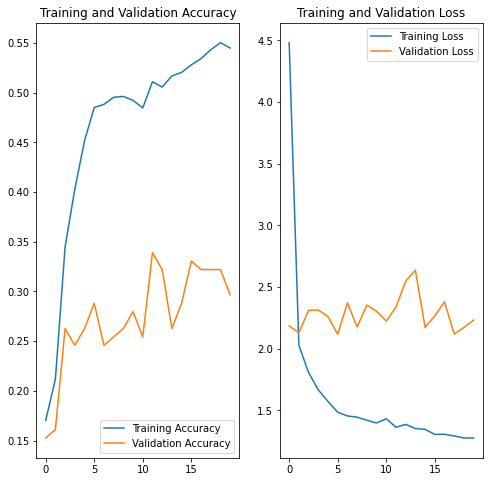

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [80]:
## Your code goes here.

train_ds_2 = image_dataset_from_directory(
    directory=data_dir_train,
    seed = 123,
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(img_height, img_width))

Found 2239 files belonging to 9 classes.


In [81]:
labelCount = []

for image, label in train_ds_2.take(-1):
    labelCount.append(class_names[label.numpy()[0]])

len(labelCount)

2239

In [86]:
def CountFrequency(my_list):
     
    # Creating an empty dictionary
    freq = {}
    for items in my_list:
        freq[items] = my_list.count(items)

    return freq

In [87]:
freq = CountFrequency(labelCount)
freq

{'actinic keratosis': 114,
 'pigmented benign keratosis': 462,
 'melanoma': 438,
 'nevus': 357,
 'dermatofibroma': 95,
 'vascular lesion': 139,
 'basal cell carcinoma': 376,
 'squamous cell carcinoma': 181,
 'seborrheic keratosis': 77}

In [88]:
def annotate_graph(ax):
    for bar in ax.patches:         
        ax.annotate(format((bar.get_height()), '.1f'), 
                    (bar.get_x() + bar.get_width() / 2,  bar.get_height()),                    
                    ha='center', va='center',                    
                    size=10, xytext=(0, 8),                    
                    textcoords='offset points')     
    return ax


In [89]:
keys = list(freq.keys())

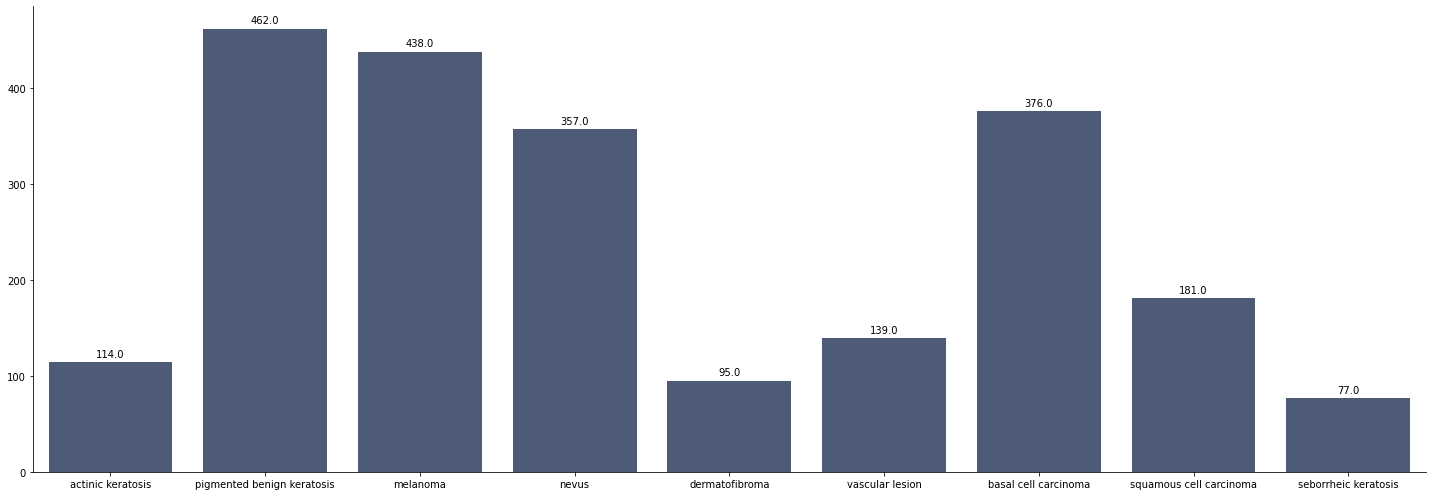

In [90]:
fig = plt.figure(figsize=(20,7))
ax = sns.barplot(x = keys, y=[freq[k] for k in keys], color = "#47597E")
ax = annotate_graph(ax)
sns.despine()
plt.tight_layout()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 
- Seborrheic Kertosis (77) 

#### - Which classes dominate the data in terms proportionate number of samples?
- Pigmented Benign Keratosis (462) 


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [142]:
# !pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [92]:
path_to_training_dataset= str(data_dir_train)+"/"

# adds the augmented files in a newly created folder called "output" inside each class folder

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/yashmishra12/Documents/Skin/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 376 image(s) found.
Output directory set to /Users/yashmishra12/Documents/Skin/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 95 image(s) found.
Output directory set to /Users/yashmishra12/Documents/Skin/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x166A02370>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to /Users/yashmishra12/Documents/Skin/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 357 image(s) found.
Output directory set to /Users/yashmishra12/Documents/Skin/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x723 at 0x166AAEC70>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to /Users/yashmishra12/Documents/Skin/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 77 image(s) found.
Output directory set to /Users/yashmishra12/Documents/Skin/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x166CFB550>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Users/yashmishra12/Documents/Skin/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 139 image(s) found.
Output directory set to /Users/yashmishra12/Documents/Skin/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x168F68550>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [11]:
# adds the augmented files in a newly created folder called "output" inside each class folder
# We are counting the total number of augmented images (which are present in the output folder of each class folder)
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


### Lets see the distribution of augmented data after adding new images to the original training data.

In [10]:
from glob import glob

In [22]:
[y for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))][0:2]

['/Users/yashmishra12/Documents/Skin/Train/melanoma/ISIC_0010550.jpg',
 '/Users/yashmishra12/Documents/Skin/Train/melanoma/ISIC_0011128.jpg']

In [23]:
[os.path.dirname(y) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))][0:2]

['/Users/yashmishra12/Documents/Skin/Train/melanoma',
 '/Users/yashmishra12/Documents/Skin/Train/melanoma']

In [24]:
[os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))][0:2]

['melanoma', 'melanoma']

In [95]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]


dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

original_df.Label.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [96]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list_new 

In [97]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [98]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [99]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [100]:
df2.Label.value_counts()

melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

In [101]:
new_df = original_df.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [113]:
new_df

,Path,Label
0,/Users/yashmishra12/Documents/Skin/Train/melan...,melanoma
1,/Users/yashmishra12/Documents/Skin/Train/melan...,melanoma
2,/Users/yashmishra12/Documents/Skin/Train/melan...,melanoma
3,/Users/yashmishra12/Documents/Skin/Train/melan...,melanoma
4,/Users/yashmishra12/Documents/Skin/Train/melan...,melanoma
...,...,...
4495,/Users/yashmishra12/Documents/Skin/Train/derma...,dermatofibroma
4496,/Users/yashmishra12/Documents/Skin/Train/derma...,dermatofibroma
4497,/Users/yashmishra12/Documents/Skin/Train/derma...,dermatofibroma
4498,/Users/yashmishra12/Documents/Skin/Train/derma...,dermatofibroma


In [125]:
histplot_label_data = []
for i in range(0,len(new_df)):
    histplot_label_data.append(new_df.iloc[i]['Label'])

In [128]:
plot_df = pd.DataFrame()

In [129]:
plot_df['Label'] = histplot_label_data

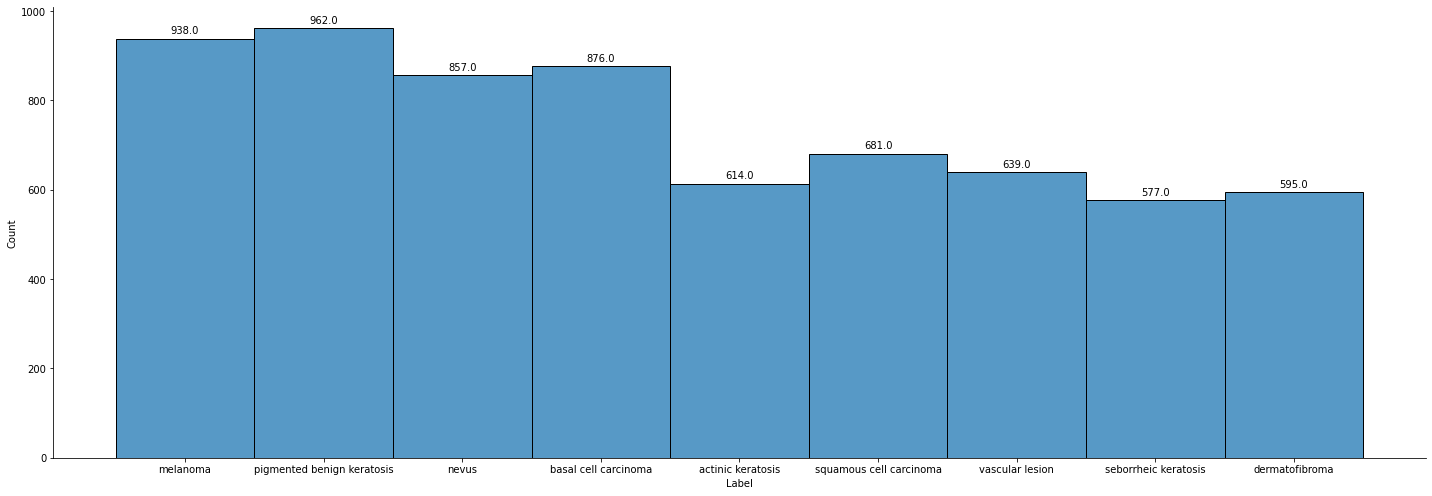

In [130]:
plt.figure(figsize=(20,7))
ax = sns.histplot(data=plot_df, x="Label")
ax = annotate_graph(ax)
sns.despine()
plt.tight_layout()


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [131]:
batch_size = 32
img_height = 180
img_width = 180

In [132]:
import shutil
import os


In [133]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [134]:
# we move the augmented images present in "output" folder to the original class folder

for name in class_names:
    source = str(data_dir_train)+"/"+name+"/output"
    destination = str(data_dir_train)+ "/" + name
    
    files = os.listdir(source)
    
    for file in files:
        file_name = os.path.join(source, file)
        shutil.move(file_name, destination)

#### **Todo:** Create a training dataset

In [135]:
data_dir_train=str(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
#   validation_split = 0.2,
#   subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.


#### **Todo:** Create a validation dataset

In [136]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
#   validation_split = 0.2,
#   subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


#### **Todo:** Create your model (make sure to include normalization)

In [137]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

    #Augmentation Layers
    model.add(RandomRotation(seed=123, factor=(-0.1, 0.1) ))
    model.add(RandomTranslation(seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ))
    model.add(RandomFlip( mode="horizontal_and_vertical", seed=123 ))
    model.add(RandomZoom( seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ))



    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())


    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [138]:
## your code goes here
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [139]:
# View the summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_rotation_5 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_translation_5 (Rando  (None, 180, 180, 3)      0         
 mTranslation)                                                   
                                                                 
 random_flip_5 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)     

#### **Todo:**  Train your model

In [140]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2021-12-30 17:54:51.424097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - ETA: 0s - loss: 2.6655 - accuracy: 0.2343

2021-12-30 17:56:24.121865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - 96s 446ms/step - loss: 2.6655 - accuracy: 0.2343 - val_loss: 2.1477 - val_accuracy: 0.0847
Epoch 2/50
211/211 [==============================] - 94s 444ms/step - loss: 1.6962 - accuracy: 0.3472 - val_loss: 2.2842 - val_accuracy: 0.2881
Epoch 3/50
211/211 [==============================] - 96s 451ms/step - loss: 1.5152 - accuracy: 0.4112 - val_loss: 2.3272 - val_accuracy: 0.2797
Epoch 4/50
211/211 [==============================] - 93s 440ms/step - loss: 1.4272 - accuracy: 0.4462 - val_loss: 2.4120 - val_accuracy: 0.3559
Epoch 5/50
211/211 [==============================] - 93s 441ms/step - loss: 1.3580 - accuracy: 0.4778 - val_loss: 2.4494 - val_accuracy: 0.3305
Epoch 6/50
211/211 [==============================] - 94s 442ms/step - loss: 1.3229 - accuracy: 0.4832 - val_loss: 2.3829 - val_accuracy: 0.3729
Epoch 7/50
211/211 [==============================] - 94s 444ms/step - loss: 1.2684 - accuracy: 0.5053 - val_loss: 2.4027 - val_accuracy: 0.3

#### **Todo:**  Visualize the model results

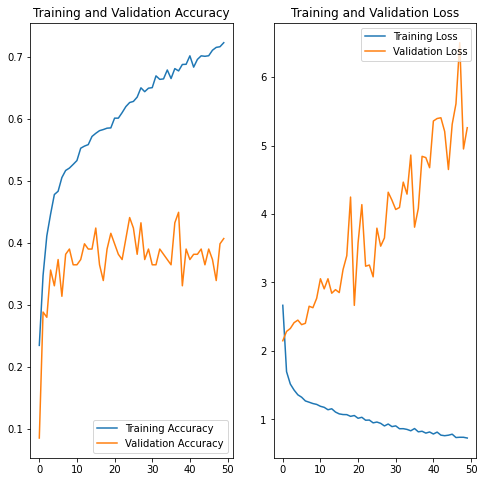

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

